# Task 1 - Multi-Class Classification

### Submission By: [Saurabh Johri](mailto:saurabhxj@gmail.com)

### Task Description
Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

### Dataset
- A set of 37500 images split into 30000 training images and 7500 testing images.
- The dataset is balanced. Each class among the 3 classes (no substructure, subhalo substructure and vortex substructure) contains equal number of samples (10000 for each class in training and 2500 for each class in testing).
- All images are one channel images with the same dimensions (100 L x 100 W).
- All images have been normalized using min max scaling.

In [1]:
# Only relevant for running on google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Unzip the dataset and create the directories to organize the training data into
%%bash

unzip -q /content/drive/MyDrive/DeepLenseGSOC/Task1/dataset.zip -d /content/

mkdir /content/image_dataset
mkdir /content/image_dataset/train
mkdir /content/image_dataset/val
mkdir /content/image_dataset/train/no
mkdir /content/image_dataset/train/sphere
mkdir /content/image_dataset/train/vort
mkdir /content/image_dataset/val/no
mkdir /content/image_dataset/val/sphere
mkdir /content/image_dataset/val/vort

In [3]:
# Requirements for installing KerasCV
%%bash
pip install -q --upgrade keras-cv tensorflow
pip install -q --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.5 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


## Proposed Strategy

- Use the KerasCV ImageClassifier Model to train a CNN for multi-class classification
- Use a GPU to accelerate the training process (NVIDIA T4 in this case, through Google Colab)
- Load and convert the images in *'.npy'* (numpy array) format to *'.png'* in order to use the keras utility for loading dataset from directory.
- Start without any data augmentation or any manipulations to establish a baseline and iterate with different techniques one-by-one if necessary.
- Use the 7500 images already separated as the testing set and split the main dataset into 90/10 split of training/validation set.

In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import numpy as np
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import roc_auc_score
from PIL import Image
from glob import glob
from tqdm import tqdm
import gc
gc.enable()

%matplotlib inline

# Path to the unzipped dataset containing .npy files
PATH = '/content/dataset'

# Path to the converted png images
IMAGE_PATH  = '/content/image_dataset'
BATCH_SIZE = 32
RANDOM_SEED = 42

keras.utils.set_random_seed(RANDOM_SEED)

### Read and convert the lense images
- Using numpy to load the images into memory
- Using Pillow library to convert a numpy array into a Pillow image that can be saved as a png.

In [5]:
for f in tqdm(glob(f'{PATH}/*/*/*.npy')):
  newimg = '/'.join(f.split('/')[-3:]).split('.')[0]
  arr = np.load(f)
  arr = np.squeeze(arr, axis=0)
  im = Image.fromarray((arr * 255).astype(np.uint8))
  im.save(f'{IMAGE_PATH}/{newimg}.png')

100%|██████████| 37500/37500 [03:22<00:00, 184.88it/s]


### Load and preprocess the dataset
- Using the keras utility *image_dataset_from_directory*
- Automatically infers the labels from the directory structure and allows for easy shuffling and other manipulation.
- Split the train directory into 90% training and 10% validation sets.
- Testing dataset is read from the *val* folder with no shuffling.

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
      f'{IMAGE_PATH}/train',
      validation_split=0.1,
      subset="training",
      label_mode='categorical',
      seed=RANDOM_SEED,
      batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
      f'{IMAGE_PATH}/train',
      validation_split=0.1,
      subset="validation",
      label_mode='categorical',
      seed=RANDOM_SEED,
      batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
      f'{IMAGE_PATH}/val',
      label_mode='categorical',
      seed=RANDOM_SEED,
      shuffle=False,
      batch_size=BATCH_SIZE)

Found 30000 files belonging to 3 classes.
Using 27000 files for training.
Found 30000 files belonging to 3 classes.
Using 3000 files for validation.
Found 7500 files belonging to 3 classes.


### Display the inferred class labels
- Class names are usually the folder names

In [7]:
class_names = train_ds.class_names
print(class_names)

['no', 'sphere', 'vort']


### Display some image samples from the dataset

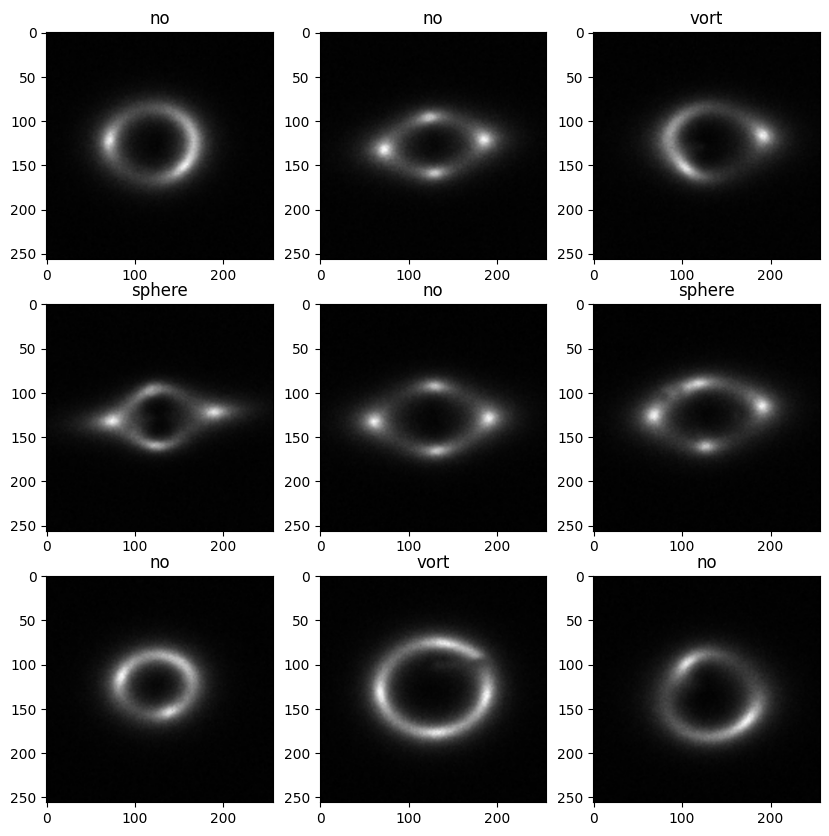

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[list(labels[i]).index(1)])

### Creating the model for training
- KerasCV contains a multitude of backbone models from models trained on the imagenet dataset.
- Using the EfficientNetV2 backbone as it requires fewer iterations to achieve similar or better performance when compared to some other counterparts.
- Might experiment with different backbones to compare performance.
- As it is a multi-class classification problem, loss function used is *categorical_crossentropy*
- Using Adam optimizer to establish a baseline, might experiment with learning rate decay later if necessary (Cosine Decay or similar)
- Using the Early Stopping callback to stop training the model and restore its weights to the best iteration if the validation loss fails to improve over *patience* (number of epochs)
- Also monitoring the model accuracy (in addition to the loss) and AUC (area under curve) to visualize model performance over epoch later on
- Defined a garbage collection callback to minimize any issues with memory leaks between epochs.

In [13]:
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_b0_imagenet"
)

model = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=3,
    activation="softmax",
)

EPOCHS = 25

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy', 'auc']
)

class GarbageCollectionCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

es = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        verbose=1,
        restore_best_weights=True)

checkpoint_path = f'/content/drive/MyDrive/DeepLenseGSOC/Task1/task_1.weights.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[GarbageCollectionCallback(), cp_callback, es]
)

Epoch 1/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.3385 - auc: 0.5027 - loss: 1.1086
Epoch 1: val_loss improved from inf to 1.08844, saving model to /content/drive/MyDrive/DeepLenseGSOC/Task1/task_1.weights.h5
844/844 ━━━━━━━━━━━━━━━━━━━━ 346s 265ms/step - accuracy: 0.3385 - auc: 0.5027 - loss: 1.1086 - val_accuracy: 0.3810 - val_auc: 0.5622 - val_loss: 1.0884
Epoch 2/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5236 - auc: 0.7213 - loss: 0.9139
Epoch 2: val_loss improved from 1.08844 to 0.36845, saving model to /content/drive/MyDrive/DeepLenseGSOC/Task1/task_1.weights.h5
844/844 ━━━━━━━━━━━━━━━━━━━━ 158s 166ms/step - accuracy: 0.5238 - auc: 0.7214 - loss: 0.9137 - val_accuracy: 0.8533 - val_auc: 0.9640 - val_loss: 0.3685
Epoch 3/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8519 - auc: 0.9604 - loss: 0.3825
Epoch 3: val_loss improved from 0.36845 to 0.29145, saving model to /content/drive/MyDrive/DeepLenseGSOC/Task1/task_1.weights.h5
844/8

### Plotting the model loss over time

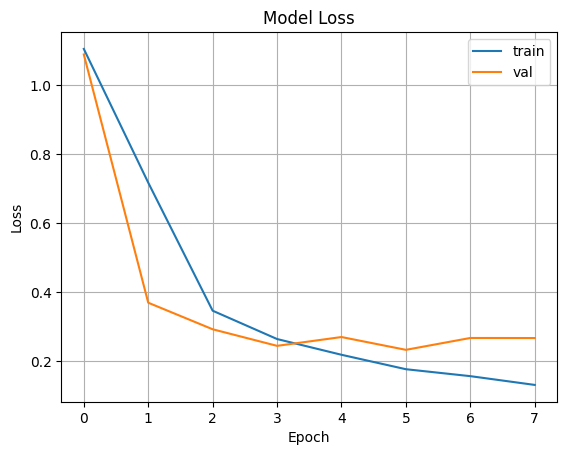

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.grid(True)
plt.show()

### Plotting the model AUC over time

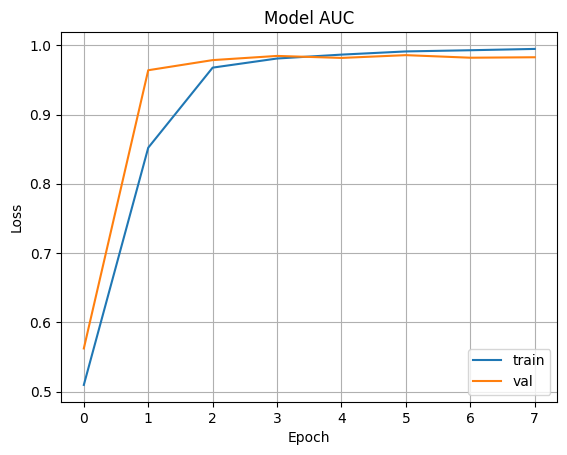

In [16]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.grid(True)
plt.show()

### Calculating the AUC score on the testing dataset
- The model has not been shown this set of images prior to training
- Considering the high AUC score on the testing dataset, additional data manipulation or augmentation might not be necessary.

In [17]:
y = np.concatenate([y for _, y in test_ds], axis=0)
prediction = model.predict(test_ds)

print(roc_auc_score(y, prediction))

235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step
0.9842483466666666


### Plotting ROC (receiver operating characteristic) curve

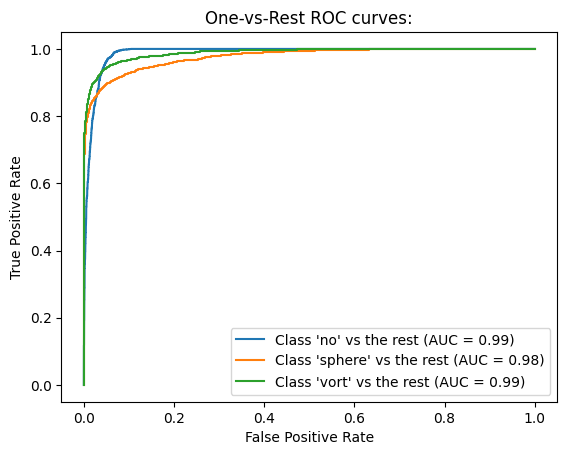

In [26]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()

for i, c in enumerate(class_names):
  display = RocCurveDisplay.from_predictions(
      y[:, i],
      prediction[:, i],
      name=f"Class \'{c}\' vs the rest",
      ax=ax
  )

  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title="One-vs-Rest ROC curves:",
  )

### Saving the entire model as an alternative option

In [27]:
model.save('/content/drive/MyDrive/DeepLenseGSOC/Task1/task_1_model.keras')